# MSE Comparison

In this notebook, we provide the numerical study to answer the question: Why BRATs do not need early-stopping to avoid overfitting.

## Helper Functions

In [6]:
from __future__ import annotations
import os
import warnings
from dataclasses import dataclass, asdict
from typing import Callable, Dict, Iterable, List, Mapping, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Optional dependencies
try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    import lightgbm as lgb
    HAS_LGB = True
except Exception:
    HAS_LGB = False

import sys, os
sys.path.insert(0, os.path.abspath("../src"))
from BRAT.algorithms import BRATD, BRATP

## Models Configurations

In [7]:
from dataclasses import dataclass, field
from typing import Optional, Dict, Callable, List, Tuple, Mapping
import numpy as np

# ---------- tree-level defaults ----------
@dataclass(frozen=True)
class TreeParams:
    max_depth: Optional[int] = 4
    min_samples_split: int = 2
    min_samples_leaf: int = 1
    sample_rate: float = 0.8   # canonical: will map to subsample/subsample_rate/etc.
    # For LightGBM users who prefer num_leaves; if None we leave LGB default
    num_leaves: Optional[int] = None

# ---------- base class for learners ----------
@dataclass(frozen=True)
class BaseLearnerConfig:
    trees: TreeParams = field(default_factory=TreeParams)
    # kept for documentation; the orchestrator will override with B at runtime
    n_estimators: int = 500

# ---------- BRAT family ----------
@dataclass(frozen=True)
class BRATDConfig(BaseLearnerConfig):
    learning_rate: float = 1.0
    dropout_rate: float = 0.5
    disable_tqdm: bool = False

@dataclass(frozen=True)
class BRATPConfig(BaseLearnerConfig):
    learning_rate: float = 1.0
    n_trees_per_group: int = 5
    disable_tqdm: bool = False
    drop_first_row: bool = False

@dataclass(frozen=True)
class BoulevardConfig(BRATDConfig):
    # Boulevard = BRATD with zero dropout
    dropout_rate: float = 0.0

# ---------- tree ensembles / libraries ----------
@dataclass(frozen=True)
class RFConfig(BaseLearnerConfig):
    bootstrap: bool = True
    n_jobs: int = -1
    warm_start: bool = True  # needed to record staged MSE by growing trees

@dataclass(frozen=True)
class GBTConfig(BaseLearnerConfig):
    # sklearn GradientBoostingRegressor
    learning_rate: float = 0.1
    # uses trees.sample_rate as subsample    (1.0 => deterministic GBT; <1 => SGBT)
    random_state_seeded: bool = True  # orchestrator passes seed to random_state

@dataclass(frozen=True)
class XGBConfig(BaseLearnerConfig):
    learning_rate: float = 0.1
    colsample_bytree: float = 0.8
    reg_lambda: float = 1.0
    tree_method: str = "hist"
    n_jobs: int = -1

@dataclass(frozen=True)
class LGBConfig(BaseLearnerConfig):
    learning_rate: float = 0.1
    colsample_bytree: float = 0.8
    n_jobs: int = -1


In [8]:
def signal(n: int, noise_std: float, seed: int) -> Tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    X = rng.uniform(0.0, 1.0, size = (n, 1))
    f = np.sin(4 * np.pi * X[:, 0])
    y = f + rng.normal(0.0, noise_std, size=n)
    return X, y

def split_train_test(
        X: np.ndarray, y: np.ndarray, test_size: int, seed: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    return train_test_split(X, y, test_size=test_size, random_state=seed)

In [9]:
def brat_tree_kwargs(t: TreeParams) -> Dict:
    # BRAT uses 'subsample_rate'
    return dict(
        max_depth=t.max_depth,
        min_samples_split=t.min_samples_split,
        # BRAT often uses only min_samples_split; include leaf if your impl supports it
        subsample_rate=t.sample_rate,
    )

def sklearn_gbt_kwargs(t: TreeParams, seed: int) -> Dict:
    return dict(
        max_depth=t.max_depth,
        min_samples_split=t.min_samples_split,
        min_samples_leaf=t.min_samples_leaf,
        subsample=t.sample_rate,        # name expected by sklearn GBT
        random_state=seed
    )

def rf_kwargs(t: TreeParams, seed: int, cfg: RFConfig) -> Dict:
    return dict(
        n_estimators=1,                 # will be increased loop-wise
        max_depth=t.max_depth,
        min_samples_leaf=t.min_samples_leaf,
        bootstrap=cfg.bootstrap,
        random_state=seed,
        n_jobs=cfg.n_jobs,
        warm_start=cfg.warm_start,
    )

def xgb_kwargs(t: TreeParams, seed: int, cfg: XGBConfig) -> Dict:
    return dict(
        max_depth=t.max_depth if t.max_depth is not None else 6,
        learning_rate=cfg.learning_rate,
        n_estimators=cfg.n_estimators,          # will be overridden by B at runtime
        subsample=t.sample_rate,                # maps to XGB subsample
        colsample_bytree=cfg.colsample_bytree,
        reg_lambda=cfg.reg_lambda,
        tree_method=cfg.tree_method,
        n_jobs=cfg.n_jobs,
        random_state=seed,
    )

def lgb_kwargs(t: TreeParams, seed: int, cfg: LGBConfig) -> Dict:
    kw = dict(
        n_estimators=cfg.n_estimators,          # will be overridden by B at runtime
        learning_rate=cfg.learning_rate,
        subsample=t.sample_rate,                # LightGBM alias of bagging_fraction
        colsample_bytree=cfg.colsample_bytree,
        n_jobs=cfg.n_jobs,
        random_state=seed,
    )
    if t.max_depth is not None:
        kw["max_depth"] = t.max_depth
    if t.num_leaves is not None:
        kw["num_leaves"] = t.num_leaves
    return kw


In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Optional deps you already guarded:
# HAS_XGB / HAS_LGB with xgboost as xgb, lightgbm as lgb imported earlier

def eval_bratd_cfg(Xtr, ytr, Xte, yte, B: int, seed: int, cfg: BRATDConfig):
    from BRAT.algorithms import BRATD
    kw_tree = brat_tree_kwargs(cfg.trees)
    model = BRATD(
        n_estimators=B,
        learning_rate=cfg.learning_rate,
        dropout_rate=cfg.dropout_rate,
        disable_tqdm=cfg.disable_tqdm,
        **kw_tree
    )
    return list(model.fit(Xtr, ytr, Xte, yte))

def eval_bratp_cfg(Xtr, ytr, Xte, yte, B: int, seed: int, cfg: BRATPConfig):
    from BRAT.algorithms import BRATP
    kw_tree = brat_tree_kwargs(cfg.trees)
    model = BRATP(
        n_estimators=B,
        learning_rate=cfg.learning_rate,
        n_trees_per_group=cfg.n_trees_per_group,
        disable_tqdm=cfg.disable_tqdm,
        drop_first_row=cfg.drop_first_row,
        **kw_tree
    )
    return list(model.fit(Xtr, ytr, Xte, yte))

def eval_boulevard_cfg(Xtr, ytr, Xte, yte, B: int, seed: int, cfg: BoulevardConfig):
    # same as BRATD with dropout=0
    return eval_bratd_cfg(Xtr, ytr, Xte, yte, B, seed, cfg)

def eval_rf_cfg(Xtr, ytr, Xte, yte, B: int, seed: int, cfg: RFConfig):
    mse = []
    kw = rf_kwargs(cfg.trees, seed, cfg)
    rf = RandomForestRegressor(**kw)
    for t in range(1, B + 1):
        rf.set_params(n_estimators=t)
        rf.fit(Xtr, ytr)
        yhat = rf.predict(Xte)
        mse.append(mean_squared_error(yte, yhat))
    return mse

def eval_gbt_cfg(Xtr, ytr, Xte, yte, B: int, seed: int, cfg: GBTConfig):
    kw = sklearn_gbt_kwargs(cfg.trees, seed)
    gbr = GradientBoostingRegressor(
        n_estimators=B, learning_rate=cfg.learning_rate, **kw
    )
    gbr.fit(Xtr, ytr)
    return [mean_squared_error(yte, yhat) for yhat in gbr.staged_predict(Xte)]

def eval_xgb(Xtr, ytr, Xte, yte, n_estimators=200, seed=0):
    if not HAS_XGB:
        return None
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        tree_method="hist",
        n_jobs=-1,
        random_state=seed,
        # <-- set here (constructor), not in fit():
        eval_metric="rmse"
    )
    # no eval_metric/verbose here
    model.fit(Xtr, ytr, eval_set=[(Xtr, ytr), (Xte, yte)])

    evals = model.evals_result()
    rmse_te = evals.get("validation_1", {}).get("rmse", [])
    return [r ** 2 for r in rmse_te]  # RMSE -> MSE

def eval_lgb(Xtr, ytr, Xte, yte, n_estimators=200, seed=0):
    if not HAS_LGB:
        return None

    eval_result = {}
    model = lgb.LGBMRegressor(
        n_estimators=n_estimators,
        num_leaves=31,
        learning_rate=0.1,
        subsample=0.8,          # a.k.a. bagging_fraction
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=seed
    )
    # Collect per-iteration metric via callbacks; don't pass 'verbose'
    model.fit(
        Xtr, ytr,
        eval_set=[(Xte, yte)],
        eval_metric="l2",  # MSE directly
        callbacks=[
            lgb.record_evaluation(eval_result),
            # lgb.log_evaluation(period=0)   # Uncomment to silence logging
        ]
    )
    return eval_result.get('valid_0', {}).get('l2', [])



In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Optional deps you already guarded:
# HAS_XGB / HAS_LGB with xgboost as xgb, lightgbm as lgb imported earlier

def eval_bratd_cfg(Xtr, ytr, Xte, yte, B: int, seed: int, cfg: BRATDConfig):
    from BRAT.algorithms import BRATD
    kw_tree = brat_tree_kwargs(cfg.trees)
    model = BRATD(
        n_estimators=B,
        learning_rate=cfg.learning_rate,
        dropout_rate=cfg.dropout_rate,
        disable_tqdm=cfg.disable_tqdm,
        **kw_tree
    )
    return list(model.fit(Xtr, ytr, Xte, yte))

def eval_bratp_cfg(Xtr, ytr, Xte, yte, B: int, seed: int, cfg: BRATPConfig):
    from BRAT.algorithms import BRATP
    kw_tree = brat_tree_kwargs(cfg.trees)
    model = BRATP(
        n_estimators=B,
        learning_rate=cfg.learning_rate,
        n_trees_per_group=cfg.n_trees_per_group,
        disable_tqdm=cfg.disable_tqdm,
        drop_first_row=cfg.drop_first_row,
        **kw_tree
    )
    return list(model.fit(Xtr, ytr, Xte, yte))

def eval_boulevard_cfg(Xtr, ytr, Xte, yte, B: int, seed: int, cfg: BoulevardConfig):
    # same as BRATD with dropout=0
    return eval_bratd_cfg(Xtr, ytr, Xte, yte, B, seed, cfg)

def eval_rf_cfg(Xtr, ytr, Xte, yte, B: int, seed: int, cfg: RFConfig):
    mse = []
    kw = rf_kwargs(cfg.trees, seed, cfg)
    rf = RandomForestRegressor(**kw)
    for t in range(1, B + 1):
        rf.set_params(n_estimators=t)
        rf.fit(Xtr, ytr)
        yhat = rf.predict(Xte)
        mse.append(mean_squared_error(yte, yhat))
    return mse

def eval_xgb_cfg(Xtr, ytr, Xte, yte, B: int, seed: int, cfg: XGBConfig):
    if not HAS_XGB:
        return None
    kw = xgb_kwargs(cfg.trees, seed, cfg)
    kw["n_estimators"] = B
    kw["eval_metric"] = "rmse"      # set IN CONSTRUCTOR, not in fit()
    kw["verbosity"] = 0           # optional: silence training printouts
    model = xgb.XGBRegressor(**kw)

    # fit: only eval_set (no eval_metric/verbose here)
    model.fit(Xtr, ytr, eval_set=[(Xtr, ytr), (Xte, yte)])
    rmse_te = model.evals_result().get("validation_1", {}).get("rmse", [])
    return [r**2 for r in rmse_te]

def eval_lgb_cfg(Xtr, ytr, Xte, yte, B: int, seed: int, cfg: LGBConfig):
    if not HAS_LGB:
        return None
    kw = lgb_kwargs(cfg.trees, seed, cfg)
    kw["n_estimators"] = B
    kw.setdefault("verbosity", -1)   # optional: silence LightGBM's logs
    model = lgb.LGBMRegressor(**kw)

    eval_result = {}
    # fit: NO 'verbose' kw; use callbacks instead
    model.fit(
        Xtr, ytr,
        eval_set=[(Xte, yte)],
        eval_metric="l2",
        callbacks=[
            lgb.record_evaluation(eval_result),
            lgb.log_evaluation(period=0),  # silence per-iter prints
            # lgb.early_stopping(stopping_rounds=50),  # optional
        ],
    )
    return eval_result.get("valid_0", {}).get("l2", [])


In [12]:
def build_model_registry_from_configs(
    cfgs: Mapping[str, BaseLearnerConfig]
) -> Mapping[str, Callable[..., Optional[List[float]]]]:
    reg = {}
    for name, cfg in cfgs.items():
        if isinstance(cfg, BRATDConfig) and not isinstance(cfg, BoulevardConfig):
            reg[name] = lambda Xtr, ytr, Xte, yte, B, seed, _cfg=cfg: \
                eval_bratd_cfg(Xtr, ytr, Xte, yte, B, seed, _cfg)
        elif isinstance(cfg, BRATPConfig):
            reg[name] = lambda Xtr, ytr, Xte, yte, B, seed, _cfg=cfg: \
                eval_bratp_cfg(Xtr, ytr, Xte, yte, B, seed, _cfg)
        elif isinstance(cfg, BoulevardConfig):
            reg[name] = lambda Xtr, ytr, Xte, yte, B, seed, _cfg=cfg: \
                eval_boulevard_cfg(Xtr, ytr, Xte, yte, B, seed, _cfg)
        elif isinstance(cfg, RFConfig):
            reg[name] = lambda Xtr, ytr, Xte, yte, B, seed, _cfg=cfg: \
                eval_rf_cfg(Xtr, ytr, Xte, yte, B, seed, _cfg)
        elif isinstance(cfg, GBTConfig):
            reg[name] = lambda Xtr, ytr, Xte, yte, B, seed, _cfg=cfg: \
                eval_gbt_cfg(Xtr, ytr, Xte, yte, B, seed, _cfg)
        elif isinstance(cfg, XGBConfig):
            reg[name] = lambda Xtr, ytr, Xte, yte, B, seed, _cfg=cfg: \
                eval_xgb_cfg(Xtr, ytr, Xte, yte, B, seed, _cfg)
        elif isinstance(cfg, LGBConfig):
            reg[name] = lambda Xtr, ytr, Xte, yte, B, seed, _cfg=cfg: \
                eval_lgb_cfg(Xtr, ytr, Xte, yte, B, seed, _cfg)
        else:
            raise ValueError(f"Unknown config type for model '{name}': {type(cfg)}")
    return reg


In [13]:
# One place to set tree behavior across models
shared_trees = TreeParams(
    max_depth=4,
    min_samples_split=2,
    min_samples_leaf=1,
    sample_rate=0.8,   # will become subsample/subsample_rate as needed
    # num_leaves=None  # for LGB: set if you want to control leaves directly
)

# Learners inherit tree params and add only their own specifics
cfgs = {
    "BRAT-D": BRATDConfig(trees=shared_trees, learning_rate=1.0, dropout_rate=0.5),
    "BRAT-P": BRATPConfig(trees=shared_trees, learning_rate=1.0, n_trees_per_group=5),
    "Boulevard": BoulevardConfig(trees=shared_trees, learning_rate=1.0),  # dropout=0
    "RF": RFConfig(trees=shared_trees),
    "GBT": GBTConfig(trees=shared_trees, learning_rate=0.1),              # subsample==0.8 via trees.sample_rate
    "SGBT (subsample=0.6)": GBTConfig(trees=TreeParams(
        max_depth=shared_trees.max_depth,
        min_samples_split=shared_trees.min_samples_split,
        min_samples_leaf=shared_trees.min_samples_leaf,
        sample_rate=0.6,   # ONLY difference vs GBT
        num_leaves=shared_trees.num_leaves
    ), learning_rate=0.1),
    "XGBoost": XGBConfig(trees=shared_trees, learning_rate=0.1, colsample_bytree=0.8),
    "LightGBM": LGBConfig(trees=shared_trees, learning_rate=0.1, colsample_bytree=0.8),
}

model_registry = build_model_registry_from_configs(cfgs)


## MSE V.S. Boosting Rounds

In [15]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, Iterable, List, Mapping, Optional, Tuple, Callable
import os, warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Data configurations

In [16]:
@dataclass
class ExpConfig:
    n: int = 1000
    noise_std: float = 2.0
    test_size: int = 200
    base_seed: int = 13

    # rounds and repeats
    B: int = 50
    repeats: int = 1

    # cache
    cache_dir: str = "./cache"
    force_recompute: bool = False

    # plotting
    log_y: bool = True
    title_single: str = "Test MSE vs. Rounds (single run)"
    title_summary: str = "Test MSE vs. Rounds — mean ± IQR"

In [17]:
def make_noisy_sinusoid(n: int, noise_std: float, seed: int) -> Tuple[np.ndarray, np.ndarray]:
    """X in [0,1], y = sin(4πx) + N(0, noise_std^2)."""
    rng = np.random.default_rng(seed)
    X = rng.uniform(0.0, 1.0, size=(n, 1))
    f = np.sin(4 * np.pi * X[:, 0])
    y = f + rng.normal(0.0, noise_std, size=n)
    return X, y

In [18]:
def split_xy(
    X: np.ndarray, y: np.ndarray, test_size: int, seed: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    return train_test_split(X, y, test_size=test_size, random_state=seed)

### Trace Utilities

In [19]:
def pad_or_trim(trace: Iterable[float], B: int) -> np.ndarray:
    """Return a length-B 1D array (pad with last value or trim)."""
    arr = np.asarray(list(trace), dtype=float)
    if arr.size == 0:
        return np.full(B, np.nan)
    if arr.size < B:
        return np.concatenate([arr, np.repeat(arr[-1], B - arr.size)])
    return arr[:B]

def summarize_traces(A: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    For input A with shape (R, B), return (mean, q25, q75) along axis=0.
    """
    mean = np.nanmean(A, axis=0)
    q25  = np.nanpercentile(A, 25, axis=0)
    q75  = np.nanpercentile(A, 75, axis=0)
    return mean, q25, q75


### Running helpers

In [20]:
def run_one_model(
    fn: Callable[[np.ndarray, np.ndarray, np.ndarray, np.ndarray, int, int], Optional[List[float]]],
    Xtr: np.ndarray, ytr: np.ndarray, Xte: np.ndarray, yte: np.ndarray,
    B: int, seed: int
) -> Optional[np.ndarray]:
    """
    Execute a single registry function and return a (B,) MSE trace (or None).
    Handles padding/trimming and None for optional deps.
    """
    out = fn(Xtr, ytr, Xte, yte, B, seed)
    if out is None:
        return None
    return pad_or_trim(out, B)

def run_all_models_one_seed(
    registry: Mapping[str, Callable[..., Optional[List[float]]]],
    Xtr: np.ndarray, ytr: np.ndarray, Xte: np.ndarray, yte: np.ndarray,
    B: int, seed: int
) -> Dict[str, np.ndarray]:
    """
    Run each model in the registry; return name -> (B,) MSE trace.
    Skips models that returned None (e.g., missing optional deps).
    """
    traces: Dict[str, np.ndarray] = {}
    for name, fn in registry.items():
        try:
            arr = run_one_model(fn, Xtr, ytr, Xte, yte, B, seed)
            if arr is not None:
                traces[name] = arr
        except Exception as e:
            warnings.warn(f"{name} failed (seed={seed}): {e}")
    return traces

### Repeat and Stacking

In [21]:
def run_repeats(
    exp: ExpConfig,
    registry: Mapping[str, Callable[..., Optional[List[float]]]],
) -> Tuple[List[str], Dict[str, np.ndarray]]:
    """
    Repeat the whole experiment exp.repeats times with seeds base_seed + r.
    Returns (model_names, stacked), where stacked[name] has shape (R_eff, B).
    """
    per_repeat: List[Dict[str, np.ndarray]] = []
    for r in range(exp.repeats):
        print(f"Running epoch {r}")
        seed = exp.base_seed + r
        X, y = make_noisy_sinusoid(exp.n, exp.noise_std, seed)
        Xtr, Xte, ytr, yte = split_xy(X, y, exp.test_size, seed)
        traces = run_all_models_one_seed(registry, Xtr, ytr, Xte, yte, exp.B, seed)
        per_repeat.append(traces)

    # Align by intersection of names, stack into (R, B)
    if not per_repeat:
        return [], {}
    names = sorted(set.intersection(*(set(d.keys()) for d in per_repeat)))
    stacked = {nm: np.vstack([d[nm][None, :] for d in per_repeat]) for nm in names}
    return names, stacked


### Caching

In [22]:
def _sanitize(name: str) -> str:
    return name.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_")

def cache_key(exp: ExpConfig) -> str:
    return f"mse_noisysinusoid_B{exp.B}_R{exp.repeats}_n{exp.n}_noise{exp.noise_std}_test{exp.test_size}.npz"

def save_cache(exp: ExpConfig, model_names: List[str], stacked: Mapping[str, np.ndarray]) -> str:
    os.makedirs(exp.cache_dir, exist_ok=True)
    path = os.path.join(exp.cache_dir, cache_key(exp))
    payload = {"model_names": np.array(model_names, dtype=object)}
    for name in model_names:
        payload[_sanitize(name)] = stacked[name]
    np.savez_compressed(path, **payload)
    return path

def load_cache(exp: ExpConfig) -> Optional[Tuple[List[str], Dict[str, np.ndarray]]]:
    path = os.path.join(exp.cache_dir, cache_key(exp))
    if not os.path.exists(path):
        return None
    npz = np.load(path, allow_pickle=True)
    names = list(npz["model_names"])
    stacked = {nm: np.array(npz[_sanitize(nm)]) for nm in names}
    return names, stacked

def run_repeats_with_cache(
    exp: ExpConfig,
    registry: Mapping[str, Callable[..., Optional[List[float]]]],
) -> Tuple[List[str], Dict[str, np.ndarray]]:
    """
    Load from cache unless force_recompute=True, else run and save.
    """
    if not exp.force_recompute:
        loaded = load_cache(exp)
        if loaded is not None:
            return loaded
    names, stacked = run_repeats(exp, registry)
    save_cache(exp, names, stacked)
    return names, stacked


### Plotting

In [23]:
OKABE_ITO = [
    "#000000", "#E69F00", "#56B4E9", "#009E73",
    "#F0E442", "#0072B2", "#D55E00", "#CC79A7",
]
_LINESTYLES = ['-', '--', '-.', ':']
_MARKERS    = ['o', 's', 'D', '^', 'v', '>', '<', 'P']

def pick_stroke_style(k: int) -> Tuple[str, str, str]:
    color = OKABE_ITO[k % len(OKABE_ITO)]
    linestyle = _LINESTYLES[(k // len(OKABE_ITO)) % len(_LINESTYLES)]
    marker = _MARKERS[k % len(_MARKERS)]
    return color, linestyle, marker

def plot_single_run(
    traces: Mapping[str, np.ndarray],
    *, log_y: bool = True, title: str = "Test MSE vs. Rounds (single run)"
) -> None:
    fig, ax = plt.subplots(figsize=(8, 5), dpi=160)
    for k, (name, arr) in enumerate(traces.items()):
        rounds = np.arange(1, arr.size + 1)
        c, ls, mk = pick_stroke_style(k)
        ax.plot(
            rounds, arr, label=name,
            linewidth=1.0, color=c, linestyle=ls,
            marker=mk, markersize=3, markevery=max(1, len(rounds)//30),
        )
    if log_y: ax.set_yscale("log")
    ax.set_xlabel("Boosting rounds")
    ax.set_ylabel("Test MSE" + (" (log scale)" if log_y else ""))
    ax.set_title(title)
    ax.legend(ncol=2, frameon=False)
    ax.grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_mean_iqr(
    model_names: List[str],
    stacked: Mapping[str, np.ndarray],
    *, log_y: bool = True,
    title: str = "Test MSE vs. Rounds — mean ± IQR",
    repeats: int = 1
) -> None:
    fig, ax = plt.subplots(figsize=(8, 5), dpi=160)
    B = next(iter(stacked.values())).shape[1]
    rounds = np.arange(1, B + 1)

    for k, name in enumerate(model_names):
        A = stacked[name]  # (R, B)
        mean, q25, q75 = summarize_traces(A)
        c, _, _ = pick_stroke_style(k)
        ax.fill_between(rounds, q25, q75, alpha=0.18, facecolor=c, edgecolor="none")
        ax.plot(rounds, mean, label=name, linewidth=1.2, color=c)

    if log_y: ax.set_yscale("log")
    ax.set_xlabel("Boosting rounds")
    ax.set_ylabel("Test MSE" + (" (log scale)" if log_y else ""))
    ax.set_title(f"{title} (R={repeats})")
    ax.legend(ncol=2, frameon=False)
    ax.grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.show()


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Okabe–Ito palette (color‑blind‑friendly)
OKABE_ITO = [
    "#000000", "#E69F00", "#56B4E9", "#009E73",
    "#F0E442", "#0072B2", "#D55E00", "#CC79A7",
]

# Marker / dash / hatch pools (cycle as needed)
_MARKERS = ['o','s','^','D','P','X','v','>','<','*','h','p']
# (len of a tuple must be even; (None, None) = solid)
_DASHES  = [(None, None), (4,2), (2,2), (6,2,2,2), (3,1,1,1), (1,1)]
_HATCHES = ['///','\\\\\\','xxx','...','ooo','***','++','--','||','///']

def _nansem(A, axis=0):
    """
    Standard error across 'axis', ignoring NaNs.
    Returns NaN where count <= 1.
    """
    # counts of finite values
    n = np.sum(np.isfinite(A), axis=axis)
    # mean with NaNs ignored
    mean = np.nanmean(A, axis=axis)
    # centered sum of squares (NaN-safe)
    diff2 = (A - np.expand_dims(mean, axis=axis))**2
    ss = np.nansum(diff2, axis=axis)
    # unbiased variance where n>1; else NaN
    var = np.where(n > 1, ss / (n - 1), np.nan)
    se = np.sqrt(var) / np.sqrt(n)
    return se

def plot_mean_iqr_distinct(  # keeping the same name for compatibility
    model_names,
    stacked,
    *,
    title=None,               # if None we'll format with se_k and repeats
    repeats=1,
    se_k=1.0,                 # <-- width multiplier: 1.0 SE (set 1.96 for ~95% CI)
    log_y=True,
    band_alpha=0.16,
    band_edge_lw=0.8,
    mean_lw=1.5,
    markevery=25,
    use_hatch=True,
    figsize=(8,5),
    dpi=160,
):
    """
    Plot mean ± (se_k * SE) per model with distinct markers and distinguishable SE bands.
    - Each model gets a unique color (Okabe–Ito), marker, and dash pattern.
    - SE band is filled with low alpha; edges outlined with dashes and sparse hollow markers.
    - Mean line has solid markers (filled) for quick identification.

    Parameters
    ----------
    stacked : dict[str, np.ndarray]
        Each value is an array of shape (R, B): R repeats × B rounds.
        NaNs are ignored in mean/SE computations column-wise.
    se_k : float
        Half-band width in units of standard error.
    """
    # Infer B and x-axis
    B = next(iter(stacked.values())).shape[1]
    rounds = np.arange(1, B + 1)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    for k, name in enumerate(model_names):
        A = stacked[name]  # shape (R, B)

        mean = np.nanmean(A, axis=0)
        se   = _nansem(A, axis=0)
        half = se_k * se

        lo = mean - half
        hi = mean + half

        color  = OKABE_ITO[k % len(OKABE_ITO)]
        marker = _MARKERS[k % len(_MARKERS)]
        dashes = _DASHES[k % len(_DASHES)]
        hatch  = _HATCHES[k % len(_HATCHES)] if use_hatch else None

        # --- SE band (fill) ---
        ax.fill_between(
            rounds, lo, hi,
            facecolor=color, alpha=band_alpha,
            edgecolor=color, linewidth=0.5,
            hatch=hatch, zorder=1
        )

        # --- SE boundaries (thin dashed lines) ---
        ax.plot(rounds, lo, color=color, linewidth=band_edge_lw, dashes=dashes, alpha=0.9, zorder=2)
        ax.plot(rounds, hi, color=color, linewidth=band_edge_lw, dashes=dashes, alpha=0.9, zorder=2)

        # --- Sparse hollow markers on band boundaries (same marker as model) ---
        me = max(1, B // markevery)
        ax.plot(
            rounds, lo, linestyle='None',
            marker=marker, markersize=4,
            markerfacecolor='white', markeredgecolor=color, markeredgewidth=0.8,
            markevery=me, zorder=3
        )
        ax.plot(
            rounds, hi, linestyle='None',
            marker=marker, markersize=4,
            markerfacecolor='white', markeredgecolor=color, markeredgewidth=0.8,
            markevery=me, zorder=3
        )

        # --- Mean line + solid markers ---
        ax.plot(rounds, mean, color=color, linewidth=mean_lw, label=name, zorder=4)
        ax.plot(
            rounds, mean, linestyle='None',
            marker=marker, markersize=5,
            markerfacecolor=color, markeredgecolor='white', markeredgewidth=0.5,
            markevery=me, zorder=5
        )

    # Axes formatting
    if log_y:
        ax.set_yscale("log")
        ylabel = "Test MSE (log scale)"
    else:
        ylabel = "Test MSE"

    if title is None:
        title = f"Test MSE vs. Rounds — mean ± {se_k:g} SE (R={repeats})"

    ax.set_xlabel("Boosting rounds")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.6)

    # Legend: show the mean line + marker only (cleanest)
    ax.legend(ncol=2, frameon=False)

    plt.tight_layout()
    plt.show()

# If you prefer to call the old name elsewhere:
# plot_mean_se_distinct = plot_mean_iqr_distinct


### Experiments Helper

In [25]:
def run_single_seed_demo(exp: ExpConfig, registry: Mapping[str, Callable[..., Optional[List[float]]]]) -> Dict[str, np.ndarray]:
    seed = exp.base_seed
    X, y = make_noisy_sinusoid(exp.n, exp.noise_std, seed)
    Xtr, Xte, ytr, yte = split_xy(X, y, exp.test_size, seed)
    traces = run_all_models_one_seed(registry, Xtr, ytr, Xte, yte, exp.B, seed)
    return traces

def main_experiment(exp: ExpConfig, registry: Mapping[str, Callable[..., Optional[List[float]]]]) -> None:
    # (A) one quick single run (sanity check)
    single = run_single_seed_demo(exp, registry)
    plot_single_run(single, log_y=exp.log_y, title=exp.title_single)

    # (B) repeats + cache + summary plot
    names, stacked = run_repeats_with_cache(exp, registry)
    plot_mean_iqr(names, stacked, log_y=exp.log_y, title=exp.title_summary, repeats=exp.repeats)


### Experiments

In [26]:
# 1) pick shared tree parameters
shared_trees = TreeParams(
    max_depth=4,
    min_samples_split=2,
    min_samples_leaf=1,
    sample_rate=0.8,  # maps to subsample/subsample_rate/etc.
)

# 2) define learners by inheriting tree params and adding only specific knobs
cfgs = {
    "BRAT-D": BRATDConfig(trees=shared_trees, learning_rate=1.0, dropout_rate=0.5),
    "BRAT-P": BRATPConfig(trees=shared_trees, learning_rate=1.0, n_trees_per_group=2),
    "Boulevard": BoulevardConfig(trees=shared_trees, learning_rate=1.0),  # dropout=0
    "RF": RFConfig(trees=shared_trees),
    "GBT": GBTConfig(trees=shared_trees, learning_rate=0.1),              # subsample=0.8 via TreeParams.sample_rate
    "SGBT (subsample=0.6)": GBTConfig(
        trees=TreeParams(
            max_depth=shared_trees.max_depth,
            min_samples_split=shared_trees.min_samples_split,
            min_samples_leaf=shared_trees.min_samples_leaf,
            sample_rate=0.6,
            num_leaves=shared_trees.num_leaves
        ),
        learning_rate=0.1
    ),
    "XGBoost": XGBConfig(trees=shared_trees, learning_rate=0.1, colsample_bytree=0.8),
    "LightGBM": LGBConfig(trees=shared_trees, learning_rate=0.1, colsample_bytree=0.8),
}

# 3) build the registry from configs
model_registry = build_model_registry_from_configs(cfgs)

# 4) set experiment parameters
exp = ExpConfig(
    n=1000, noise_std=2.0, test_size=200,
    base_seed=13, B=500, repeats=30,
    cache_dir="./cache", force_recompute=False,
)

# 5) run
# main_experiment(exp, model_registry)


### Cache the result

In [27]:
# --- Load the cached results from the run you already did ---
exp.force_recompute = False  # make sure we never recompute
loaded = load_cache(exp)     # uses exp.cache_dir + cache_key(exp)

if loaded is None:
    raise FileNotFoundError(
        f"No cache found for {cache_key(exp)} in {exp.cache_dir}. "
        "If you just changed exp settings, re-run main_experiment once."
    )

model_names, stacked = loaded  # stacked[name] has shape (repeats, B)
print("Loaded models:", model_names)
print("Per-model array shapes:", {k: v.shape for k, v in stacked.items()})


Loaded models: ['BRAT-D', 'BRAT-P', 'Boulevard', 'GBT', 'LightGBM', 'RF', 'SGBT (subsample=0.6)', 'XGBoost']
Per-model array shapes: {'BRAT-D': (30, 500), 'BRAT-P': (30, 500), 'Boulevard': (30, 500), 'GBT': (30, 500), 'LightGBM': (30, 500), 'RF': (30, 500), 'SGBT (subsample=0.6)': (30, 500), 'XGBoost': (30, 500)}


In [28]:
import numpy as np
import pandas as pd

def to_long_summary_df(model_names, stacked):
    """One row per (model, round) with mean, q25, q75."""
    B = next(iter(stacked.values())).shape[1]
    rounds = np.arange(1, B + 1)
    rows = []
    for name in model_names:
        A = stacked[name]  # (R, B)
        mean, q25, q75 = summarize_traces(A)
        rows.extend((name, int(r), float(m), float(l), float(u))
                    for r, m, l, u in zip(rounds, mean, q25, q75))
    return pd.DataFrame(rows, columns=["model", "round", "mean", "q25", "q75"])

def to_long_per_repeat_df(model_names, stacked):
    """One row per (model, repeat, round) with the raw MSE."""
    rows = []
    for name in model_names:
        A = stacked[name]  # (R, B)
        R, B = A.shape
        for rep in range(R):
            for r in range(B):
                rows.append((name, rep, r + 1, float(A[rep, r])))
    return pd.DataFrame(rows, columns=["model", "repeat", "round", "mse"])

df_summary = to_long_summary_df(model_names, stacked)
df_perrep  = to_long_per_repeat_df(model_names, stacked)

df_summary.head(), df_perrep.head()


(    model  round      mean       q25       q75
 0  BRAT-D      1  4.998832  4.562150  5.446686
 1  BRAT-D      2  4.781668  4.419132  5.026697
 2  BRAT-D      3  4.463959  4.190285  4.774130
 3  BRAT-D      4  4.322054  4.006621  4.647293
 4  BRAT-D      5  4.279904  4.017258  4.551460,
     model  repeat  round       mse
 0  BRAT-D       0      1  4.728428
 1  BRAT-D       0      2  4.417947
 2  BRAT-D       0      3  4.271799
 3  BRAT-D       0      4  4.161593
 4  BRAT-D       0      5  4.145164)

In [29]:
import os, time

snap_dir = os.path.join(exp.cache_dir, "snapshots")
os.makedirs(snap_dir, exist_ok=True)

stamp = time.strftime("%Y%m%d-%H%M%S")
base  = f"mse_snapshot_B{exp.B}_R{exp.repeats}_{stamp}"

# Save tidy CSV/Parquet
df_summary.to_csv(os.path.join(snap_dir, base + "_summary.csv"), index=False)
df_perrep.to_csv(os.path.join(snap_dir, base + "_perrep.csv"), index=False)

# You already have the NPZ cache, but you can write a copy with a stable name:
npz_copy_path = os.path.join(snap_dir, base + ".npz")
save_cache(exp, stacked=stacked, model_names=model_names)  # writes the standard cache file
import shutil
shutil.copy2(os.path.join(exp.cache_dir, cache_key(exp)), npz_copy_path)

print("Saved snapshot to:", snap_dir)


Saved snapshot to: ./cache/snapshots


### Replotting without training

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Okabe–Ito palette (color‑blind‑friendly)
OKABE_ITO = [
    "#000000", "#E69F00", "#56B4E9", "#009E73",
    "#F0E442", "#0072B2", "#D55E00", "#CC79A7",
]

# Marker / dash / hatch pools (cycle as needed)
_MARKERS = ['o','s','^','D','P','X','v','>','<','*','h','p']
# (len of a tuple must be even; (None, None) = solid)
_DASHES  = [(None, None), (4,2), (2,2), (6,2,2,2), (3,1,1,1), (1,1)]
_HATCHES = ['///','\\\\\\','xxx','...','ooo','***','++','--','||','///']

def _nansem(A, axis=0):
    """
    Standard error across 'axis', ignoring NaNs.
    Returns NaN where count <= 1.
    """
    # counts of finite values
    n = np.sum(np.isfinite(A), axis=axis)
    # mean with NaNs ignored
    mean = np.nanmean(A, axis=axis)
    # centered sum of squares (NaN-safe)
    diff2 = (A - np.expand_dims(mean, axis=axis))**2
    ss = np.nansum(diff2, axis=axis)
    # unbiased variance where n>1; else NaN
    var = np.where(n > 1, ss / (n - 1), np.nan)
    se = np.sqrt(var) / np.sqrt(n)
    return se

def plot_mean_std_distinct(  # keeping the same name for compatibility
    model_names,
    stacked,
    *,
    title=None,               # if None we'll format with se_k and repeats
    repeats=1,
    se_k=1.0,                 # <-- width multiplier: 1.0 SE (set 1.96 for ~95% CI)
    log_y=True,
    band_alpha=0.16,
    band_edge_lw=0.8,
    mean_lw=1.5,
    markevery=25,
    use_hatch=False,
    figsize=(8,5),
    dpi=160,
):
    """
    Plot mean ± (se_k * SE) per model with distinct markers and distinguishable SE bands.
    - Each model gets a unique color (Okabe–Ito), marker, and dash pattern.
    - SE band is filled with low alpha; edges outlined with dashes and sparse hollow markers.
    - Mean line has solid markers (filled) for quick identification.

    Parameters
    ----------
    stacked : dict[str, np.ndarray]
        Each value is an array of shape (R, B): R repeats × B rounds.
        NaNs are ignored in mean/SE computations column-wise.
    se_k : float
        Half-band width in units of standard error.
    """
    # Infer B and x-axis
    B = next(iter(stacked.values())).shape[1]
    rounds = np.arange(1, B + 1)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    for k, name in enumerate(model_names):
        A = stacked[name]  # shape (R, B)

        mean = np.nanmean(A, axis=0)
        se   = _nansem(A, axis=0)
        half = se_k * se

        lo = mean - half
        hi = mean + half

        color  = OKABE_ITO[k % len(OKABE_ITO)]
        # marker = _MARKERS[k % len(_MARKERS)]
        # dashes = _DASHES[k % len(_DASHES)]
        hatch  = _HATCHES[k % len(_HATCHES)] if use_hatch else None

        # --- SE band (fill) ---
        ax.fill_between(
            rounds, lo, hi,
            facecolor=color, alpha=band_alpha,
            edgecolor=color, linewidth=0.5,
            hatch=hatch, zorder=1
        )

        # --- SE boundaries (thin dashed lines) ---
        #ax.plot(rounds, lo, color=color, linewidth=band_edge_lw, alpha=0.9, zorder=2)
        #ax.plot(rounds, hi, color=color, linewidth=band_edge_lw, alpha=0.9, zorder=2)

        #--- Sparse hollow markers on band boundaries (same marker as model) ---
        #me = max(1, B // markevery)
        #ax.plot(
        #    rounds, lo, linestyle='None',
        #    marker=marker, markersize=4,
        #    markerfacecolor='white', markeredgecolor=color, markeredgewidth=0.8,
        #    markevery=me, zorder=3
        #)
        #ax.plot(
        #    rounds, hi, linestyle='None',
        #    marker=marker, markersize=4,
        #    markerfacecolor='white', markeredgecolor=color, markeredgewidth=0.8,
        #    markevery=me, zorder=3
        #)

        # --- Mean line + solid markers ---
        ax.plot(rounds, mean, color=color, linewidth=mean_lw, label=name, zorder=4)
        #ax.plot(
        #    rounds, mean, linestyle='None',
        #    marker=marker, markersize=5,
        #    markerfacecolor=color, markeredgecolor='white', markeredgewidth=0.5,
        #    markevery=me, zorder=5
        #)

    # Axes formatting
    if log_y:
        ax.set_yscale("log")
        ylabel = "Test MSE (log scale)"
    else:
        ylabel = "Test MSE"

    if title is None:
        title = f"Test MSE vs. Rounds — mean ± {se_k:g} SE (R={repeats})"

    ax.set_xlabel("Boosting rounds")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.6)

    # Legend: show the mean line + marker only (cleanest)
    ax.legend(ncol=2, frameon=False)

    plt.tight_layout()
    plt.show()

# If you prefer to call the old name elsewhere:
# plot_mean_se_distinct = plot_mean_iqr_distinct


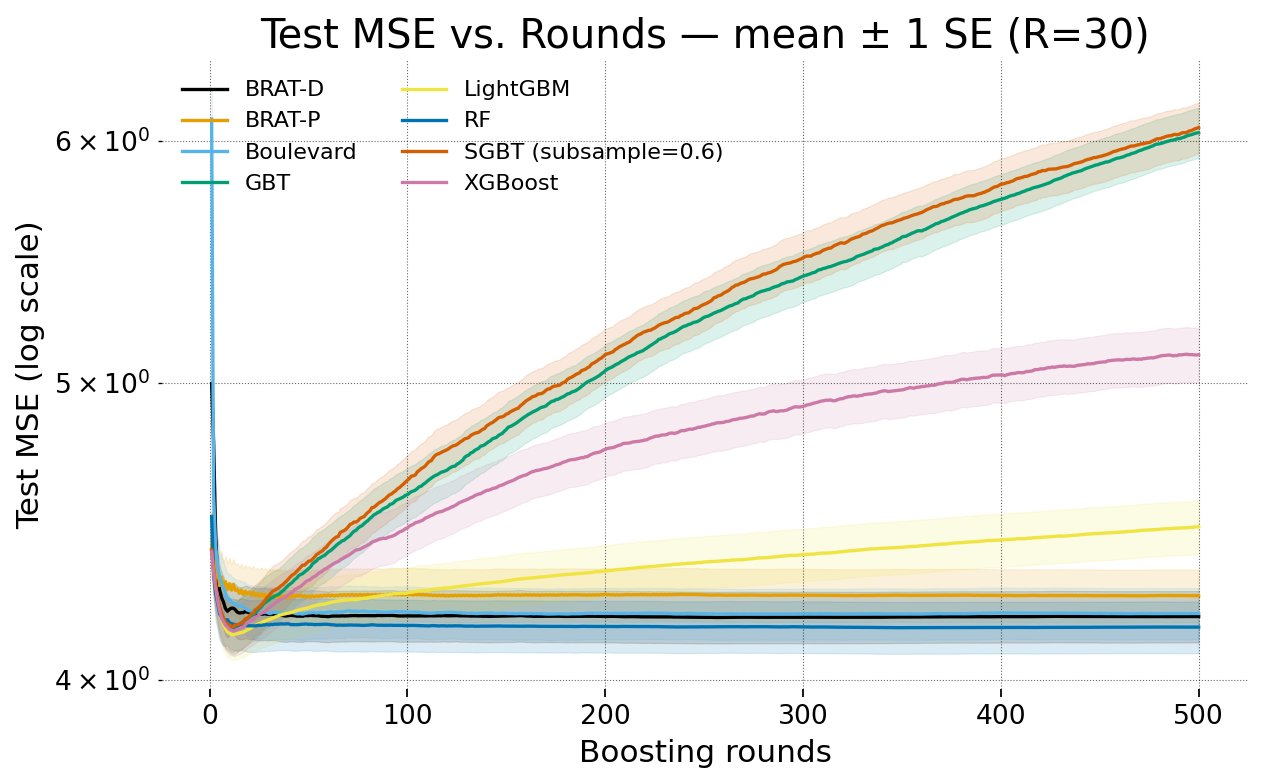

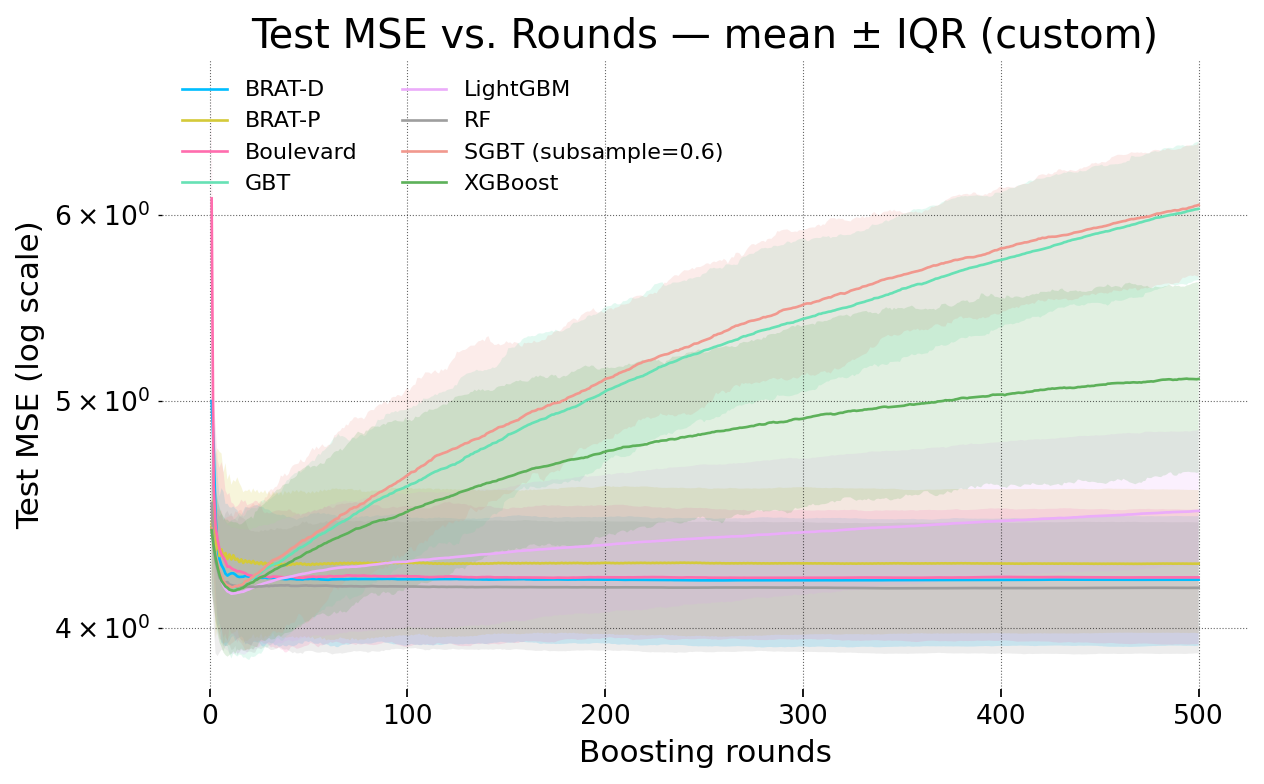

In [31]:
# Example: tweak labels, grid, and whether to use log scale
# You already loaded from cache:
# model_names, stacked = load_cache(exp)

plot_mean_std_distinct(
    model_names, stacked,
    repeats=exp.repeats,
    log_y=True,          # toggle to False for linear scale
    markevery=30,        # fewer/more markers along curves/boundaries
    use_hatch=False,      # set False if you prefer no texture
    band_alpha=0.14,     # tweak overlap transparency
)


# Or build a custom Matplotlib plot from df_summary
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5), dpi=160)
for k, name in enumerate(model_names):
    d = df_summary[df_summary["model"] == name]
    plt.fill_between(d["round"], d["q25"], d["q75"], alpha=0.18, label=None)
    plt.plot(d["round"], d["mean"], label=name, linewidth=1.2)
plt.yscale("log")
plt.xlabel("Boosting rounds")
plt.ylabel("Test MSE (log scale)")
plt.title("Test MSE vs. Rounds — mean ± IQR (custom)")
plt.legend(ncol=2, frameon=False)
plt.grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


# Storage

Running this block should yield the mean, upper/lower bound trajectories, saved in `mse_trajectories.csv`

In [ ]:
# Rename the quantile columns
df_summary = df_summary.rename(columns={'q25': 'mu - sigma', 'q75': 'mu + sigma'})

# Compute the standard deviation estimate
df_summary['std'] = (df_summary['mu + sigma'] - df_summary['mu - sigma']) / 2

# Save the updated DataFrame to CSV
df_summary.to_csv('mse_trajectory.csv', index=False)

# Optionally display the first few rows to confirm
import pandas as pd
print(df_summary.head())